In [1]:
# Minor Project
# DataCan: Data Analysis and Prediction for Cancer Dataset
# by  Varun Goel
#     Vishal Jangir
#     Tushar Ranjan

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("paper")
import matplotlib.pyplot as plt
import re
import itertools
import pickle

import nltk
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale, FunctionTransformer
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC, NuSVC
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multiclass import OneVsRestClassifier


[nltk_data] Downloading package punkt to C:\Users\Varun
[nltk_data]     Goel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Varun
[nltk_data]     Goel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)

    ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
5   5     CBL                 V391I      4
6   6     CBL                 V430M      5
7   7     CBL              Deletion      1
8   8     CBL                 Y371H      4
9   9     CBL                 C384R      4

    ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...
5   5  Oncogenic mutations in the monomeric Casitas B...
6   6  Oncogenic mut

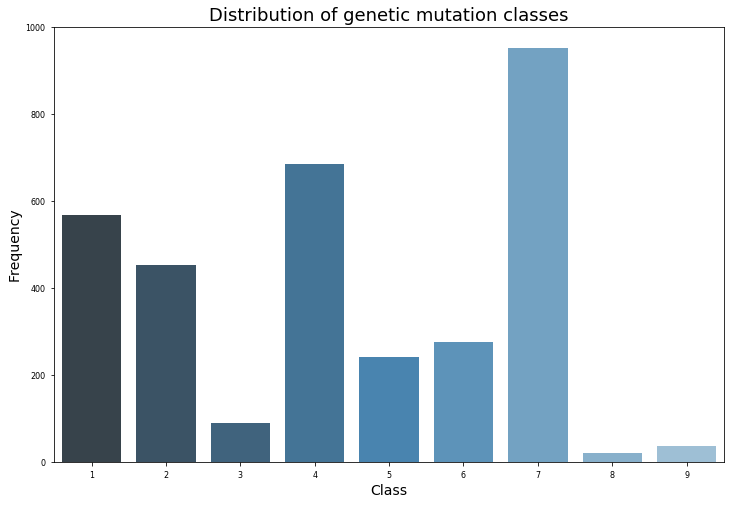

Genes with maximal occurences
 Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

Genes with minimal occurences
 Gene
KLF4      1
FGF19     1
FANCC     1
FAM58A    1
PAK1      1
ERRFI1    1
PAX8      1
PIK3R3    1
PMS1      1
PPM1D     1
Name: Gene, dtype: int64


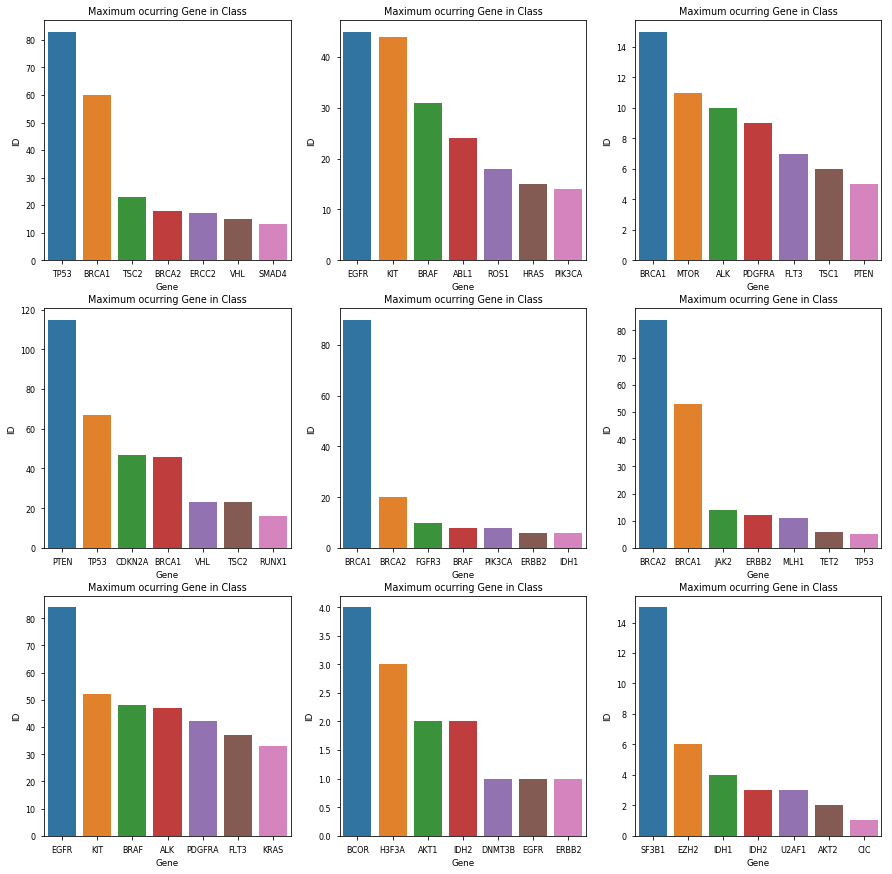

In [2]:

train_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
train_text_df = pd.read_csv("training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv("test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print("Train Variant".ljust(15), train_variants_df.shape)
print("Train Text".ljust(15), train_text_df.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)

print("\n",train_variants_df.head(10))
print("\n", train_text_df.head(10))

print("\nFor training data, there are a total of", len(train_variants_df.ID.unique()), "IDs,", end='')
print(len(train_variants_df.Gene.unique()), "unique genes,", end='')
print(len(train_variants_df.Variation.unique()), "unique variations and ", end='')
print(len(train_variants_df.Class.unique()),  "classes")

#print(train_variants_df.describe())

plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_variants_df, palette="Blues_d")
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

gene_group = train_variants_df.groupby("Gene")['Gene'].count()
minimal_occ_genes = gene_group.sort_values(ascending=True)[:10]
print("Genes with maximal occurences\n", gene_group.sort_values(ascending=False)[:10])
print("\nGenes with minimal occurences\n", minimal_occ_genes)

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants_df[train_variants_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j]).set_title("Maximum ocurring Gene in Class")
        
        




In [3]:
#Converting Variants into Mutation Types
point_mutation_pattern = \
        r"[ARNDCEQGHILKMFPSTWYV]{1}[0-9]{1,4}[ARNDCEQGHILKMFPSTWYV*]?$"
    
train_variants_df['mutation_type'] = train_variants_df['Variation']

major_types = ['Truncation', 'Point Mutation', 'Deletion', 'Promoter Mutations',
       'Amplification', 'Epigenetic', 'Frame Shift', 'Overexpression',
       'Deletion-Insertion', 'Duplication', 'Insertion',
       'Gene Subtype', 'Fusion', 'Splice', 'Copy Number Loss', 'Wildtype']

train_variants_df.loc[(train_variants_df['Variation'].str.match(point_mutation_pattern)), 'mutation_type']= 'Point Mutation'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('missense', case=False)), 'mutation_type']= 'Point Mutation'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('fusion', case=False)), 'mutation_type']= 'Fusion'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('deletion', case=False)), 'mutation_type']= 'Deletion'
train_variants_df.loc[((train_variants_df['Variation'].str.contains('del', case=False))\
               & (train_variants_df['Variation'].str.contains('delins', case=False) == False)), 
                'mutation_type']= 'Deletion'
train_variants_df.loc[((train_variants_df['Variation'].str.contains('ins', case=False))\
               & (train_variants_df['Variation'].str.contains('delins', case=False) == False)), 
                'mutation_type']= 'Insertion'
train_variants_df.loc[((train_variants_df['Variation'].str.contains('del', case=False))\
               & (train_variants_df['Variation'].str.contains('delins', case=False))), 
                'mutation_type']= 'Deletion-Insertion'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('dup', case=False)), 'mutation_type']= 'Duplication'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('trunc', case=False)), 'mutation_type']= 'Truncation'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('fs', case=False)), 'mutation_type']= 'Frame Shift'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('splice', case=False)), 'mutation_type']= 'Splice'
train_variants_df.loc[(train_variants_df['Variation'].str.contains('exon', case=False)), 'mutation_type']= 'Point Mutation'
train_variants_df.loc[((train_variants_df['Variation'].str.contains('EGFR', case=False))\
                |(train_variants_df['Variation'].str.contains('AR', case=True))\
                |(train_variants_df['Variation'].str.contains('MYC-nick', case=True))\
                |(train_variants_df['Variation'].str.contains('TGFBR1', case=True))\
                |(train_variants_df['Variation'].str.contains('CASP8L', case=True))),
                'mutation_type']= 'Gene Subtype'
train_variants_df.loc[((train_variants_df['Variation'].str.contains('Hypermethylation', case=False))\
                |(train_variants_df['Variation'].str.contains('Epigenetic', case=False))),
                'mutation_type']= 'Epigenetic'
train_variants_df.loc[(train_variants_df['mutation_type'].isin(major_types) == False),
                'mutation_type']= 'Others'

print(len(train_variants_df['mutation_type'].unique()),'\n')
print('Major Mutation Types:-\n',train_variants_df['mutation_type'].unique(),'\n')

train_variants_df = train_variants_df[['ID', 'Gene', 'Variation', 'mutation_type', 'Class']]
#print(train_variants_df.head())

17 

Major Mutation Types:-
 ['Truncation' 'Point Mutation' 'Deletion' 'Promoter Mutations'
 'Amplification' 'Epigenetic' 'Frame Shift' 'Overexpression'
 'Gene Subtype' 'Deletion-Insertion' 'Duplication' 'Insertion' 'Fusion'
 'Splice' 'Copy Number Loss' 'Others' 'Wildtype'] 



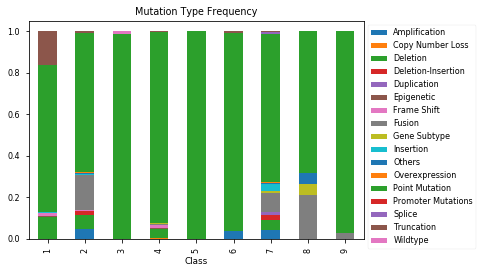

In [4]:
#Mutation Type Frequency in each Class
d1 =train_variants_df[['mutation_type', 'Class']].groupby(['Class','mutation_type']).size().unstack('mutation_type')
for i in range(len(d1)):
     d1.iloc[i] /= np.sum(d1.iloc[i])
d1.plot(kind='bar',title = "Mutation Type Frequency", stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)



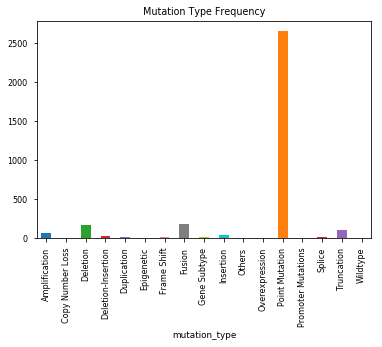

In [5]:
#Mutation type frequency
train_variants_df.groupby('mutation_type').size().plot(kind='bar',title ="Mutation Type Frequency", stacked=True)


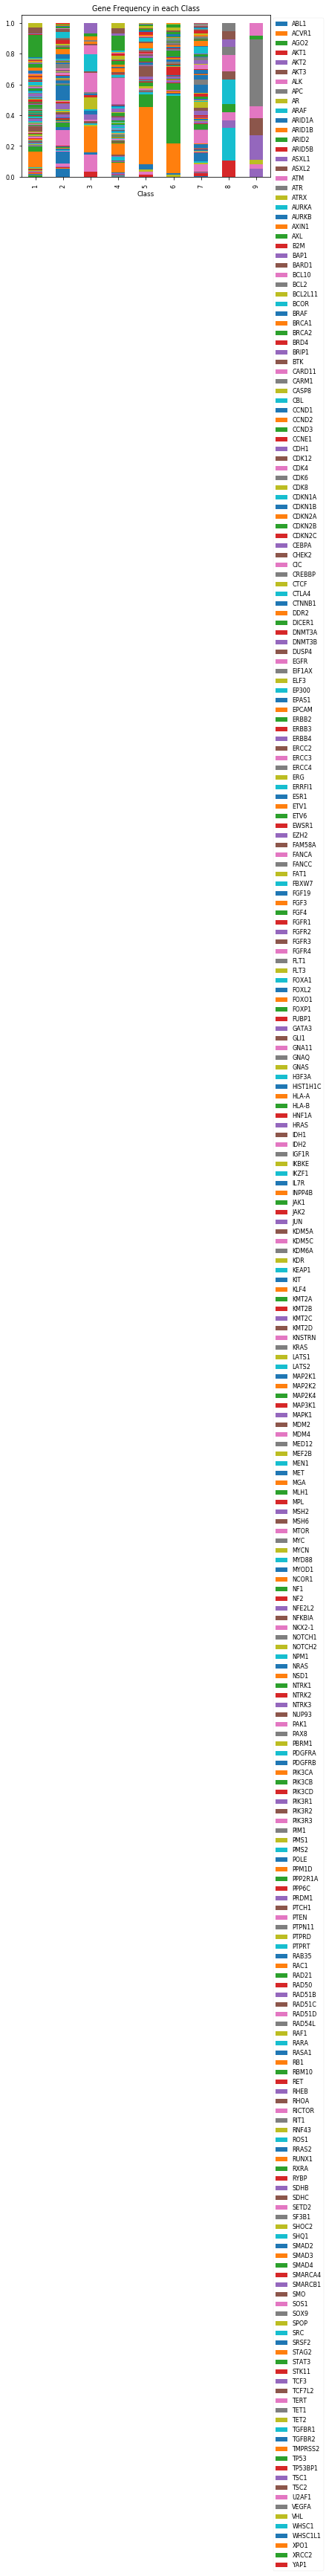

In [6]:
#Gene Frequency in each Class
g1 = train_variants_df.groupby(['Gene', 'Class']).size().unstack('Gene')
for i in range(len(g1)):
    g1.iloc[i] /= np.sum(g1.iloc[i])
g1.plot(kind='bar',title ="Gene Frequency in each Class", stacked=True, legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...   

   ID     Gene Variation                                               Text
0   0    ACSL4     R570S  2. This mutation resulted in a myeloproliferat...
1   1    NAGLU     P521L   Abstract The Large Tumor Suppressor 1 (LATS1)...
2   2      PAH     L333F  Vascular endothelial growth factor receptor (V...
3   3     ING1     A148D  Inflammatory myofibroblastic tumor (IMT) is a ...
4   4  TMEM

F:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


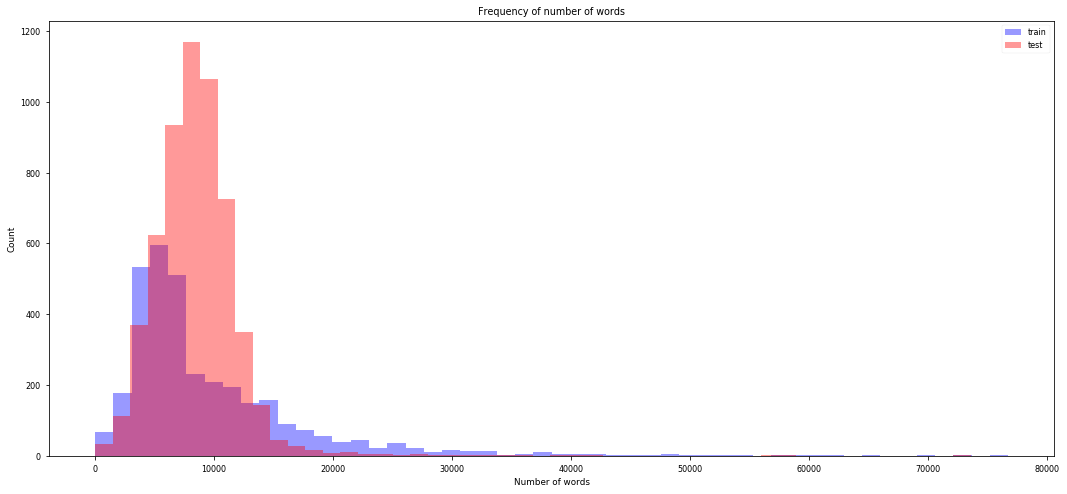

In [7]:
#Merging variants and text DataFrames on ID for train and test
train_variants_df.drop(['mutation_type'], axis = 1, inplace = True)
train = pd.merge(train_variants_df, train_text_df, how='left', on='ID')
test = pd.merge(test_variants_df, test_text_df, how='left', on='ID')

print(train.head(),'\n')
print(test.head())

train["Text_Count"] = train["Text"].apply(lambda x: len(str(x).split()) )
test["Text_Count"] = test["Text"].apply(lambda x: len(str(x).split()) )

#Plot the number of words distribution for train and text datasets
fig, ax = plt.subplots(figsize=(18, 8))
sns.distplot(train.Text_Count.values, bins=50, kde=False, color='blue',ax=ax)
sns.distplot(test.Text_Count.values, bins=50, kde=False, color='red',ax=ax)
ax.set(xlabel='Number of words', ylabel='Count', title= "Frequency of number of words")
plt.legend(['train','test'])



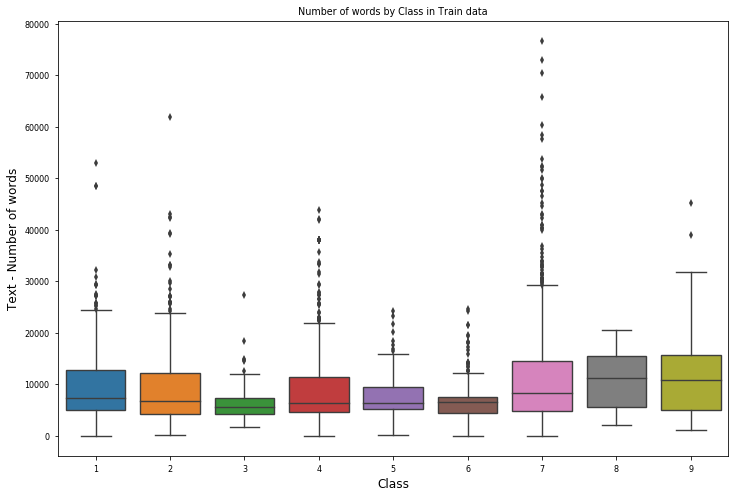

In [8]:
#Plot the number of words distribution for each class in combined text
plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='Text_Count', data=train)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.title('Number of words by Class in Train data')
plt.show()

In [8]:
#Functions for:-
#           1.Tokenizing words
#           2.Creating Mutation Word table 
#           3.Get gene-like words
#           4.Converting Variants to Mutation Types

#Process for converting text to tokenize words
def process_text(text, print_on=False):
    # Tokenize the text
    word_tokens = word_tokenize(text)
    
    # Remove some unwanted words (hyphen excluded), and numbers
    remove_list = ['.', ',', '(', ')', '[', ']', '=', '+', '>', '<', ':', ';', '%']
    word_tokens = [word for word in word_tokens if word not in remove_list]
    word_tokens = [word for word in word_tokens if (word.isnumeric() == False)]
    
    # Remove Stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in word_tokens if not w in stop_words]
    
    # print if print_on=True
    if print_on:
        print('Length Before removing stop words %d' % len(word_tokens))
        print('Length After removing stop words %d' % len(words))
    
    return words

#Create Mutation Word table
def create_mutation_words_table(tokenized_text, normed=False):
    
    # List of words for mutation types
    mutation_patterns = ['truncation', 'deletion', 'promoter','amplification', 'epigenetic', 'frame', 'overexpression',
                     'duplication', 'insertion','subtype', 'fusion', 'splice', 'wildtype']
    
    appearances = []
    for pattern in mutation_patterns:
        appearance = len([word for word in tokenized_text if pattern in word.lower()])
        appearances.append(appearance)
    
    if normed == 'mutation_types':
        appearances = np.array(appearances)
        if np.sum(appearances) != 0:
            appearances = appearances / np.sum(appearances)
        table = dict(zip(mutation_patterns, appearances))
    elif normed == 'total_text':
        appearances = np.array(appearances)
        appearances = appearances / len(tokenized_text)
        table = dict(zip(mutation_patterns, appearances))
    else:
        table = dict(zip(mutation_patterns, appearances))
        table['Total'] = np.sum(appearances)
    
    return table

#Get gene-like words
def get_gene_like_words(tokenized_text, gene_list=None):
    gene_ish_pattern = r"[A-Z]{2,7}"
    gene_like_words = [word for word in tokenized_text if re.match(gene_ish_pattern, word)]
    
    if gene_list is not None:
        genes = gene_list
        for gene in genes:
            for i in range(len(gene_like_words)):
                if gene in gene_like_words[i]:
                    gene_like_words[i] = gene
    
    return gene_like_words

#Converting Variants to Mutation Types
def convert_mutation_type(data):
    # Copy the Variation into a new column 
    data['mutation_type'] = data['Variation']

    # Define regex pattern for point mutants
    point_mutation_pattern = \
        r"[ARNDCEQGHILKMFPSTWYV]{1}[0-9]{1,4}[ARNDCEQGHILKMFPSTWYV*]?$"

    # Define new mutation types
    major_types = ['Truncation', 'Point Mutation', 'Deletion', 'Promoter Mutations',
       'Amplification', 'Epigenetic', 'Frame Shift', 'Overexpression',
       'Deletion-Insertion', 'Duplication', 'Insertion',
       'Gene Subtype', 'Fusion', 'Splice', 'Copy Number Loss', 'Wildtype']

    # Convert the Variant information to mutation types
    data.loc[(data['Variation'].str.match(point_mutation_pattern)), 'mutation_type']= 'Point Mutation'
    data.loc[(data['Variation'].str.contains('missense', case=False)), 'mutation_type']= 'Point Mutation'
    data.loc[(data['Variation'].str.contains('fusion', case=False)), 'mutation_type']= 'Fusion'
    data.loc[(data['Variation'].str.contains('deletion', case=False)), 'mutation_type']= 'Deletion'
    data.loc[((data['Variation'].str.contains('del', case=False))\
            &(data['Variation'].str.contains('delins', case=False) == False)),
            'mutation_type']= 'Deletion'
    data.loc[((data['Variation'].str.contains('ins', case=False))\
            &(data['Variation'].str.contains('delins', case=False) == False)),
            'mutation_type']= 'Insertion'
    data.loc[((data['Variation'].str.contains('del', case=False))\
            &(data['Variation'].str.contains('delins', case=False))),
            'mutation_type']= 'Deletion-Insertion'
    data.loc[(data['Variation'].str.contains('dup', case=False)), 'mutation_type']= 'Duplication'
    data.loc[(data['Variation'].str.contains('trunc', case=False)), 'mutation_type']= 'Truncation'
    data.loc[(data['Variation'].str.contains('fs', case=False)), 'mutation_type']= 'Frame Shift'
    data.loc[(data['Variation'].str.contains('splice', case=False)), 'mutation_type']= 'Splice'
    data.loc[(data['Variation'].str.contains('exon', case=False)), 'mutation_type']= 'Point Mutation'
    data.loc[((data['Variation'].str.contains('EGFR', case=False))\
            |(data['Variation'].str.contains('AR', case=True))\
            |(data['Variation'].str.contains('MYC-nick', case=True))\
            |(data['Variation'].str.contains('TGFBR1', case=True))\
            |(data['Variation'].str.contains('CASP8L', case=True))),
            'mutation_type']= 'Gene Subtype'
    data.loc[((data['Variation'].str.contains('Hypermethylation', case=False))\
            |(data['Variation'].str.contains('Epigenetic', case=False))),
             'mutation_type']= 'Epigenetic'
    data.loc[(data['mutation_type'].isin(major_types) == False),
            'mutation_type']= 'Others'

    # rearrange order of columns
    if 'Class' in data.columns:
        data = data[['ID', 'Gene', 'Variation', 'mutation_type', 'Class']]
    else:
        data = data[['ID', 'Gene', 'Variation', 'mutation_type']]

    return data

In [ ]:
#Creating a Mutation Table using text train data
mut_words_list = []
for i in range(len(train_text_df)):
    text = train_text_df.fillna("").loc[i, 'Text']
    tokens = process_text(text)
    mut_words = create_mutation_words_table(tokens, normed='mutation_types')
    mut_words_list.append(mut_words)
    
full_mutation_table = pd.DataFrame(mut_words_list)
full_mutation_table.to_csv("full_mutation_table.csv")
print(full_mutation_table.head())

In [9]:
full_mutation_table = pd.read_csv("full_mutation_table.csv").drop(['Unnamed: 0'],axis=1)
print(full_mutation_table.head())

   amplification  deletion  duplication  epigenetic     frame    fusion  \
0       0.000000  0.527778     0.027778         0.0  0.027778  0.166667   
1       0.000000  0.666667     0.000000         0.0  0.000000  0.000000   
2       0.000000  0.666667     0.000000         0.0  0.000000  0.000000   
3       0.166667  0.333333     0.055556         0.0  0.000000  0.166667   
4       0.000000  0.000000     0.000000         0.0  1.000000  0.000000   

   insertion  overexpression  promoter    splice   subtype  truncation  \
0   0.027778        0.055556       0.0  0.138889  0.000000    0.027778   
1   0.000000        0.000000       0.0  0.166667  0.166667    0.000000   
2   0.000000        0.000000       0.0  0.166667  0.166667    0.000000   
3   0.000000        0.222222       0.0  0.000000  0.055556    0.000000   
4   0.000000        0.000000       0.0  0.000000  0.000000    0.000000   

   wildtype  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


In [ ]:
#Creating Gene-like Words Table using both Text and Variants Dataset
genes = list(train_variants_df['Gene'].unique())
glike_words_list = []
for i in range(len(train_text_df)):
    text = train_text_df.fillna("").loc[i, 'Text']
    tokens = process_text(text)
    glike_words = get_gene_like_words(tokens, gene_list=genes)
    c = dict(Counter(glike_words))
    glike_words_list.append(c)

glike_words_table = pd.DataFrame(glike_words_list)
glike_words_table.to_csv("glike_words_table.csv")
print(glike_words_table.head())

In [10]:
glike_words_table = pd.read_csv("glike_words_table.csv").drop(['Unnamed: 0'],axis=1)
print(glike_words_table.head())

   AA  AA-3'5  AA-30  AA-3555  AA-3V  AA-3â€²  AA-3â€™  AA-A00N  AA-N131Y  \
0 NaN     NaN    NaN      NaN    NaN      NaN      NaN      NaN       NaN   
1 NaN     NaN    NaN      NaN    NaN      NaN      NaN      NaN       NaN   
2 NaN     NaN    NaN      NaN    NaN      NaN      NaN      NaN       NaN   
3 NaN     NaN    NaN      NaN    NaN      NaN      NaN      NaN       NaN   
4 NaN     NaN    NaN      NaN    NaN      NaN      NaN      NaN       NaN   

   AA-V600EB-Raf  ...   ZW3  ZWILCH  ZWINT  ZYX  ZZ  ZZ-TAZ2  ZZ-type  ZZO  \
0            NaN  ...   NaN     NaN    NaN  NaN NaN      NaN      NaN  NaN   
1            NaN  ...   NaN     NaN    NaN  NaN NaN      NaN      NaN  NaN   
2            NaN  ...   NaN     NaN    NaN  NaN NaN      NaN      NaN  NaN   
3            NaN  ...   NaN     NaN    NaN  NaN NaN      NaN      NaN  NaN   
4            NaN  ...   NaN     NaN    NaN  NaN NaN      NaN      NaN  NaN   

   ZZQ  ZZZQ  
0  NaN   NaN  
1  NaN   NaN  
2  NaN   NaN  
3  NaN  

In [11]:
#Gene vs each ID Table
X_gene = np.array(train_variants_df.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()

print(X_gene_int,"\n")

full_gene_table = pd.DataFrame(X_gene_bin)
print(full_gene_table.head(),"\n")

print(full_gene_table.loc[:, 39].head(10))

[[ 85]
 [ 39]
 [ 39]
 ...
 [221]
 [221]
 [221]] 

   0    1    2    3    4    5    6    7    8    9   ...   254  255  256  257  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   258  259  260  261  262  263  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 264 columns] 

0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: 39, dtype: float64


In [12]:
#Mutation Type vs ID using Variants Dataset
new_table = convert_mutation_type(train_variants_df)

X_mtype = np.array(new_table['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
print(X_mtype_int)

full_muttype_table = pd.DataFrame(X_mtype_bin)
print(full_muttype_table.head())

[[15]
 [12]
 [12]
 ...
 [ 7]
 [12]
 [12]]
    0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

    15   16  
0  1.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  


In [13]:
#Merging all tables and train-test split
full_mutation_table = full_mutation_table.fillna(value=0)
glike_words_table = glike_words_table.fillna(value=0)
full_gene_table = full_gene_table.fillna(value=0)
full_muttype_table = full_muttype_table.fillna(value=0)

features = pd.concat([full_mutation_table, 
                      glike_words_table,
                      full_gene_table,
                      full_muttype_table],
                      axis=1)

print(features.shape)

X = np.array(features).astype(float)
y = np.array(train_variants_df.Class).astype(int).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state=0)


(3321, 47793)


In [22]:
#Using Random-Forest with GridSearchCV for prediction 

rfc = RandomForestClassifier(n_estimators=200, max_depth = 50, random_state= 0)

param_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': [20, 30, 40, 50]}

grid_rfc = GridSearchCV(rfc, param_grid, cv=10)
grid_rfc.fit(X_train, y_train)

print(grid_rfc.best_estimator_)
print(grid_rfc.best_params_)
print(grid_rfc.best_score_)

(3321, 47793)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
{'max_depth': 50, 'n_estimators': 200}
0.6619812583668006


In [50]:
#Random Forest with Pickle to save trained model
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
rfc.fit(X_train, y_train)

fname = 'rfc.sav'
pickle.dump(rfc, open(fname, "wb"))
 

In [51]:
#Loading saved model and using 10-fold cross-validation
random_forest = pickle.load(open(fname, "rb"))
y_pred = rfc.predict(X_test)
print('Accuracy Score: ')
print(accuracy_score(y_test, y_pred))
print('10-Fold Cross Validation Score: \n')
print(cross_val_score(rfc, X_train, y_train, cv=10))

class_names = ['1','2','3','4','5','6','7','8','9']
print('Classification Report: \n')
print(classification_report(y_test, y_pred, target_names = class_names))

Accuracy Score: 
0.6546546546546547
10-Fold Cross Validation Score: 

[0.65 0.68 0.68 0.67 0.64 0.64 0.66 0.66 0.66 0.68]
Classification Report: 

             precision    recall  f1-score   support

          1       0.61      0.65      0.63        51
          2       0.63      0.41      0.50        46
          3       0.50      0.36      0.42        11
          4       0.67      0.80      0.73        75
          5       0.56      0.25      0.34        20
          6       0.95      0.66      0.78        32
          7       0.62      0.78      0.69        94
          8       1.00      0.50      0.67         2
          9       1.00      1.00      1.00         2

avg / total       0.66      0.65      0.64       333



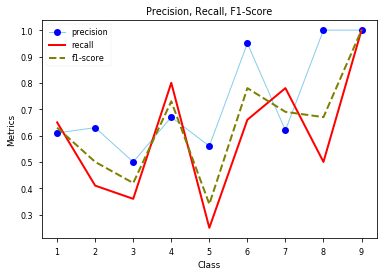

In [45]:
#Precision, Recall and F1-Score Curve
df=pd.DataFrame({'class': (1,2,3,4,5,6,7,8,9), 
                 'precision': (0.61,0.63,0.50,0.67,0.56,0.95,0.62,1.00,1.00), 
                 'recall': (0.65,0.41,0.36,0.80,0.25,0.66,0.78,0.50,1.00), 
                 'f1-score': (0.63,0.50,0.42,0.73,0.34,0.78,0.69,0.67,1.00)})

plt.plot( 'class', 'precision', data=df, marker='o', markerfacecolor='blue', markersize=7, color='skyblue', linewidth=1)
plt.plot( 'class', 'recall', data=df, marker='', color='red', linewidth=2)
plt.plot( 'class', 'f1-score', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.xlabel('Class')
plt.ylabel('Metrics')
plt.title('Precision, Recall, F1-Score')
plt.legend()


Confusion matrix, without normalization
[[33  1  0 11  0  1  5  0  0]
 [ 1 19  0  2  1  0 23  0  0]
 [ 1  0  4  3  0  0  3  0  0]
 [10  0  0 60  0  0  5  0  0]
 [ 7  0  1  3  5  0  4  0  0]
 [ 0  1  1  3  1 21  5  0  0]
 [ 2  8  2  7  2  0 73  0  0]
 [ 0  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  2]]


Normalized confusion matrix
[[0.65 0.02 0.   0.22 0.   0.02 0.1  0.   0.  ]
 [0.02 0.41 0.   0.04 0.02 0.   0.5  0.   0.  ]
 [0.09 0.   0.36 0.27 0.   0.   0.27 0.   0.  ]
 [0.13 0.   0.   0.8  0.   0.   0.07 0.   0.  ]
 [0.35 0.   0.05 0.15 0.25 0.   0.2  0.   0.  ]
 [0.   0.03 0.03 0.09 0.03 0.66 0.16 0.   0.  ]
 [0.02 0.09 0.02 0.07 0.02 0.   0.78 0.   0.  ]
 [0.   0.5  0.   0.   0.   0.   0.   0.5  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


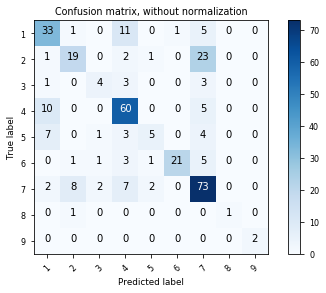

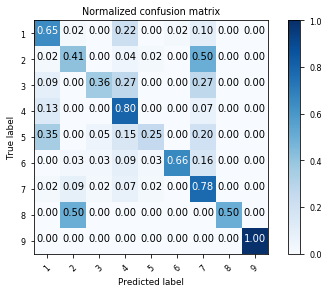

In [19]:
#Confusion Matrix
class_names = ['1','2','3','4','5','6','7','8','9']
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
print("\n")

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [28]:
#Preprocessing
train.isnull().sum()
train.dropna(inplace=True)
train.isnull().sum()

X = train[['Gene', 'Variation', 'Text']]
print(X.head(), "\n")

y = train['Class']
print(y.head(), "\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print('Shapes', '\n'
      'X:',X.shape,'\n'
      'y:',y.shape,'\n'
      'X_train:',X_train.shape, '\n'
      'X_test:',X_test.shape,'\n' 
      'y_train:',y_train.shape,'\n' 
      'y_test:',y_test.shape
     )

     Gene             Variation  \
0  FAM58A  Truncating Mutations   
1     CBL                 W802*   
2     CBL                 Q249E   
3     CBL                 N454D   
4     CBL                 L399V   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...   

0    1
1    2
2    2
3    3
4    4
Name: Class, dtype: int64 

Shapes 
X: (3316, 3) 
y: (3316,) 
X_train: (2221, 3) 
X_test: (1095, 3) 
y_train: (2221,) 
y_test: (1095,)


In [25]:
#Defining Classes
class FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.column]

class CategoricalExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column
        self.values = None
        
    def _create_values(self, indices):
        return {ind: i+1 for i, ind in enumerate(indices)}
    
    def _apply_values(self, row_val):
        return self.values.get(row_val, 0)
        
    def fit(self, X, y=None):
        self.values = self._create_values(X[self.column].value_counts().index)
        return self 
    
    def transform(self, X, y=None):
        col = X[self.column].apply(self._apply_values)
        return col.values.reshape(-1, 1)

In [29]:
#Make Pipeline
text_pipe = make_pipeline(
    FeatureExtractor('Text'),
    CountVectorizer(stop_words='english'),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True)
)

gene_pipe = make_pipeline(
    CategoricalExtractor('Gene'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

var_pipe = make_pipeline(
    CategoricalExtractor('Variation'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

fu = make_union(text_pipe, gene_pipe, var_pipe)

model_pipe = make_pipeline(fu, OneVsRestClassifier(estimator=SVC(probability=True)))

In [30]:
#Fitting model
model_pipe.fit(X_train, y_train)
print(model_pipe.score(X_train, y_train))

0.835209365150833
